In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
#plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
plotsize_subplots = (16,3)

fontsize_axis = 9
fontsize_labels = 9
fontsize_legends = 8

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

# Benchmarks

## SLI Benchmarks

## HPC Benchmark - weak scaling

Conn. Creation (min)                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST 3.0 (a641eec1e)   
N_VP                                                                  
36                  47.47                69.92                56.66   
72                  47.47                72.80                56.59   
144                 47.41                72.66                57.06   
288                 47.67                71.04                57.37   
576                 47.48                71.13                58.23   
1152                47.59                  NaN                  NaN   

                          Conn. Exchange (min)                       \
Case NEST RNG (9443a8907)            NEST 2.20 NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36                  75.49                51.06                79.20   
72                  74.07                54.56                81.26   
144                 71.16                56.86                81.98   
288                 72.05                63.50                84.68   
576                 74.76                79.77                89.41   
1152                73.66               108.10                  NaN   

                                               Conn. Total  \
Case NEST 3.0 (a641eec1e) NEST RNG (9443a8907)   NEST 2.20   
N_VP                                                         
36                  77.80                78.70      100.88   
72                  80.93                81.15      106.29   
144                 80.88                85.74      108.38   
288                 85.66                85.07      113.49   
576                 89.80                90.94      131.74   
1152                  NaN                93.22      159.98   

                                                                     \
Case NEST 3.0 (8f5a5fc1e) NEST 3.0 (a641eec1e) NEST RNG (9443a8907)   
N_VP                                                                  
36                 158.72               145.19               169.34   
72                 169.13               150.17               174.88   
144                166.18               149.15               172.75   
288                169.43               156.76               181.05   
576                176.24               161.55               188.11   
1152                  NaN                  NaN               192.40   

     Memory per VP                                            \
Case     NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST 3.0 (a641eec1e)   
N_VP                                                           
36        2.819082             2.886640             2.890740   
72        2.834828             2.892702             2.893303   
144       2.908171             2.978537             2.980969   
288       2.913480             2.983866             2.983796   
576       3.051638             3.074016             3.068073   
1152      3.395655                  NaN                  NaN   

                          Simulation time                       \
Case NEST RNG (9443a8907)       NEST 2.20 NEST 3.0 (8f5a5fc1e)   
N_VP                                                             
36               2.886351          191.81               203.83   
72               2.889157          199.87               211.11   
144              2.979875          199.12               217.54   
288              2.983984          212.72               230.29   
576              3.074798          228.70               242.58   
1152             3.451043          267.55                  NaN   

                                                
Case NEST 3.0 (a641eec1e) NEST RNG (9443a8907)  
N_VP                                            
36                 204.21               234.33  
72                 207.42               242.69  
144                211.14               244.87  
288                225.03               253.43  
576        

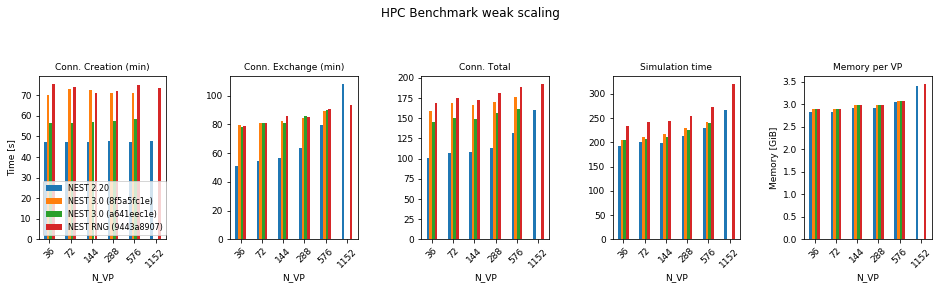

In [13]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['NEST 2.20'] * len(hpc_220)

hpc_3_a6 = pd.read_csv('results/hpc_benchmark_3_0_a641eec1e_daint.csv')
hpc_3_a6['Case'] = ['NEST 3.0 (a641eec1e)'] * len(hpc_3_a6)
hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv')
hpc_3_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_3_8f)

hpc_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint.csv')
hpc_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_rng)

hpc = pd.concat([hpc_220, hpc_3_a6, hpc_3_8f, hpc_rng])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/rng/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')

hpc_p

## HPC Benchmark - strong scaling

Conn. Creation (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                         0.61                 0.93                 0.95   
12                        0.30                 0.48                 0.49   
24                        0.15                 0.24                 0.26   
48                        0.08                 0.13                 0.13   
96                        0.04                 0.07                 0.07   
192                       0.02                  NaN                 0.04   
384                       0.01                  NaN                 0.02   
768                       0.00                  NaN                 0.02   

          Conn. Exchange (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                         0.68                 1.13                 1.20   
12                        0.47                 0.63                 0.65   
24                        0.31                 0.35                 0.36   
48                        0.29                 0.29                 0.24   
96                        0.16                 0.15                 0.18   
192                       0.18                  NaN                 0.13   
384                       0.20                  NaN                  NaN   
768                       0.18                  NaN                 0.28   

          Conn. Total                                            \
Case        NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                         
6                1.48                 2.31                 2.52   
12               0.80                 1.23                 1.34   
24               0.49                 0.68                 0.76   
48               0.82                 0.50                 0.46   
96               0.61                 0.29                 0.32   
192              0.88                  NaN                 0.21   
384              0.94                  NaN                  NaN   
768              0.71                  NaN                 0.33   

          Memory per task                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                             
6                0.635518             1.097183             1.083729   
12               0.540298             0.994475             0.979556   
24               0.461600             0.925828             0.924947   
48               0.760461             1.118091             0.839632   
96               0.372274             0.836309             0.831420   
192              0.346288                  NaN             0.789341   
384              0.348532                  NaN                  NaN   
768              0.347982                  NaN             0.779703   

          Simulation time                                            
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)  
num_tasks                                                            
6                    6.69                 7.38                 9.11  
12                   3.83                 4.02                 4.84  
24                   2.42                 2.27                 2.67  
48                   8.71                 6.01                 1.74  
96                   2.10                 1.82                 1.75  
192                  2.74                  NaN                 1.78  
384                  3.36                  NaN                  NaN  
768                  3.62                  NaN                 2.23

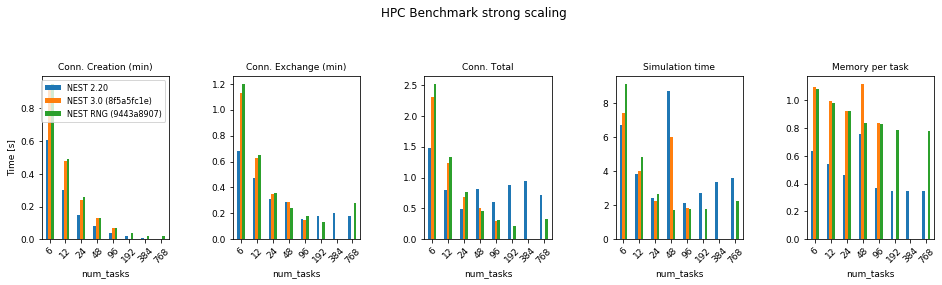

In [15]:
hpc_strong_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_strong_scaling.csv')
hpc_strong_220['Case'] = ['NEST 2.20'] * len(hpc_strong_220)

hpc_3_strong_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint_strong_scaling.csv')
hpc_3_strong_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_3_strong_8f)

hpc_strong_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint_strong_scaling.csv')
hpc_strong_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_strong_rng)

hpc_strong = pd.concat([hpc_strong_220, hpc_3_strong_8f, hpc_strong_rng])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
hpc_strong['Memory per task'] = (hpc_strong['VSize_sum']/hpc_strong['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hpc_strong_p = plot_compare(hpc_strong, 'figures/rng/hpc_benchmark_strong_scaling.pdf',
                            values=values, index='num_tasks',
                            legend_loc='upper right',
                            title='HPC Benchmark strong scaling')

hpc_strong_p

## Python Benchmarks

## Population model - with simulation, weak scaling

0    0
1    0
2    0
3    0
4    0
5    0
0    0
1    0
2    0
3    0
4    0
5    0
Name: N_spks_sum, dtype: int64


Conn. Creation (min)                      Conn. Exchange (min)  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36              47.274928            48.470755            49.880384   
72              68.480578            70.500262            64.193010   
144             87.065022            88.949677            67.351998   
288            123.370981           124.134125            71.028175   
576            200.750428           200.855462           120.947394   
1152           352.575103           349.540493            89.643744   

                                   Conn. Total                       \
Case NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
N_VP                                                                  
36              48.779330           107.008492           110.685591   
72              62.490629           141.911463           149.264497   
144             63.568594           165.734244           168.632432   
288             69.486607           206.770948           206.607486   
576             72.265913           334.067568           290.703984   
1152           136.419465           459.256482           507.138250   

            Memory per VP                           Simulation time  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36               2.333985             2.323274            30.894495   
72               3.091078             3.029287            38.788532   
144              3.237555             3.112640            64.797525   
288              3.371930             3.371703           167.480526   
576              3.373050             3.373023           125.315002   
1152             3.431286             3.434789           141.806240   

                           
Case NEST RNG (9443a8907)  
N_VP                       
36              80.386662  
72              80.574523  
144             80.773935  
288            174.201580  
576            232.462918  
1152           199.295813

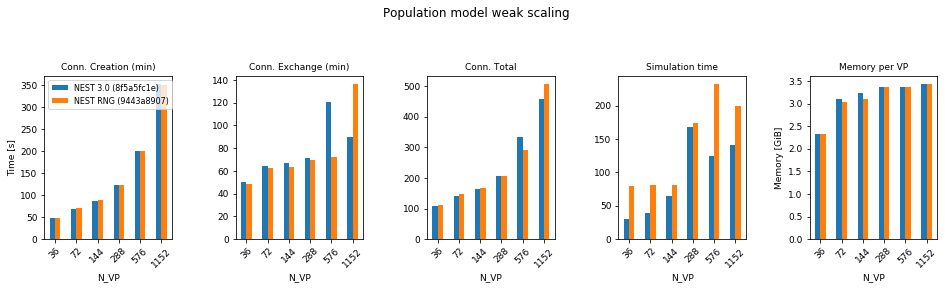

In [24]:
pop_220 = pd.read_csv('results/population_model_2_20_37722d5e3_daint_in_scale4.csv')
pop_220['Case'] = ['NEST 2.20'] * len(pop_220)

pop_3_8f = pd.read_csv('results/population_model_3_0_8f5a5fc1e_daint.csv')
pop_3_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(pop_3_8f)
pop_3_a6 = pd.read_csv('results/population_model_3_0_a641eec1e_daint_in_scale4.csv')
pop_3_a6['Case'] = ['NEST 3.0 (a641eec1e)'] * len(pop_3_a6)

pop_rng = pd.read_csv('results/rng/population_model_rng_9443a8907_daint.csv')
pop_rng['Case'] = ['NEST RNG (9443a8907)'] * len(pop_rng)

pop = pd.concat([pop_3_8f, pop_rng])

pop = calculate_T_conn_and_memory(pop)
pop_p = plot_compare(pop, 'figures/rng/population_model_weak_scaling.pdf', legend_loc='upper left',
                     title='Population model weak scaling')

print(pop['N_spks_sum'])

pop_p

## Population model - with simulation, strong scaling

Conn. Creation (min)                      Conn. Exchange (min)  \
Case      NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
num_tasks                                                                  
12                   85.541871            88.139236            80.091807   
24                   54.366502            55.578962            41.351880   
48                   38.561891            38.962357            21.927554   
96                   31.326425            31.345915            12.732042   
192                  27.528834            27.369665             8.197193   
384                  25.466670            25.189880             6.730836   
768                  24.167019            23.844734             3.802465   

                                        Conn. Total                       \
Case      NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
12                   76.745035           177.825204           180.555321   
24                   39.500992           103.232310           103.071377   
48                   22.690205            64.370464            66.994738   
96                   12.441035            46.081574            46.630359   
192                   8.582129            37.057137            37.730863   
384                   6.734804            33.579323            33.202596   
768                   4.009909            29.445947            29.077293   

               Memory per task                           Simulation time  \
Case      NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
num_tasks                                                                  
12                   22.206545            21.824729            50.482684   
24                   12.874696            12.303752            38.683829   
48                    7.999607             7.965570            33.560266   
96                    5.381572             5.396871            26.828480   
192                   4.439219             4.466074            49.814960   
384                   3.651798             3.660821            41.328887   
768                   2.824413             2.833563            30.294724   

                                
Case      NEST RNG (9443a8907)  
num_tasks                       
12                  102.921283  
24                   48.921535  
48                   50.323684  
96                   39.558214  
192                  54.650863  
384                  43.173785  
768                  32.243013

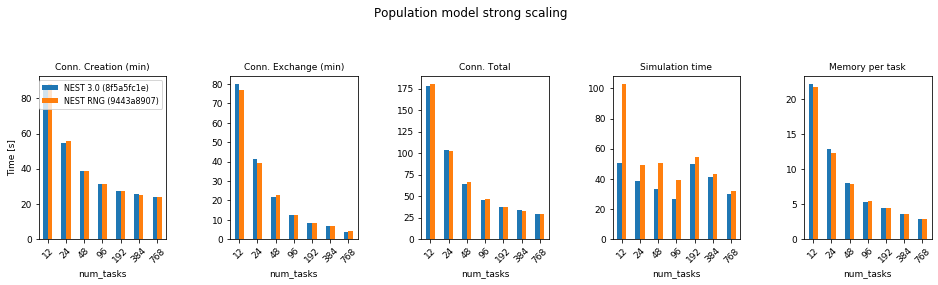

In [31]:
pop_strong_220 = pd.read_csv('results/population_model_2_20_daint_strong_scaling_in.csv')
pop_strong_220['Case'] = ['NEST 2.20'] * len(pop_strong_220)

pop_3_strong_8f = pd.read_csv('results/population_model_3_0_8f5a5fc1e_daint_strong_scaling.csv')
pop_3_strong_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(pop_3_strong_8f)

pop_strong_rng = pd.read_csv('results/rng/population_model_rng_9443a8907_daint_strong_scaling.csv')
pop_strong_rng['Case'] = ['NEST RNG (9443a8907)'] * len(pop_strong_rng)

pop_strong = pd.concat([pop_3_strong_8f, pop_strong_rng])

pop_strong = calculate_T_conn_and_memory(pop_strong)
pop_strong['Memory per task'] = (pop_strong['VSize_sum']/pop_strong['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
pop_strong_p = plot_compare(pop_strong, 'figures/rng/population_model_strong_scaling.pdf',
                            values=values, index='num_tasks', plot_T_sim=True,
                            legend_loc='upper right',
                            title='Population model strong scaling')

pop_strong_p